# Testing Notebook
Notebook for testing the constraints.jl code. Note that this notebook has now been synced to a Julia script file in the `percent` format using `jupytext`.  Use that file for comparing revisions. See [Collaborating on notebooks with git](https://github.com/mwouts/jupytext#collaborating-on-notebooks-with-git) for more details.

## Load constraints

In [1]:
include("constraints.jl")

plotConstraint (generic function with 1 method)

## Define plotting functions

In [2]:
function plotConstraints(adm::ADM)
    #adm = ADM(rM=1e-2,m=5.11,dα=0.01)
    #fig,h1 = plotConstraint(getLSSProperties,ADM(),name="LSS SM")
    #display(adm)
    fig,hlss = plotConstraint(getLSSProperties,adm,name="LSS")
    _,hms = plotConstraint(getDwGalProperties,adm,fig=fig,name="Miss Sat")
    _,hdb = plotConstraint(getDBCProperties,adm,fig=fig,name="DBC")
    _,hdco = plotConstraint(getDCOProperties,adm,fig=fig,name="\$10^6-10^9\$ Halos Cool",ctype=strucform)
    _,hmw = plotConstraint(getMWProperties,adm,fig=fig,name="MW no cool",ctype=strucform)
    println("Plotted Constraints")
    handles = [hlss[1],hms[1],hdb[1],hdco[1],hmw[1]]
    T = 10 .^ range(-2,10,length=50)
    zBH=5
    nBH = nofz(adm.M,zBH)
    nBH = 1
    println("nBH:$nBH")
    ΛSM = get_Lambda.(nBH,T)
    #println("Post SM")
    ΛP = get_Lambda.(nBH,T;adm)
    #push!(handles,loglog(T,ΛSM,linestyle="dashdot",label="SM")[1]) # loglog returns a 1 element list
    push!(handles,loglog(T,ΛP,linestyle="solid",label="M=$(adm.M) GeV m=$(adm.m) keV")[1])
    legend(;handles)
    title("M:$(adm.M) GeV m:$(adm.m) keV α\$_D\$:$(adm.dα)")
end

function plotExamplePoints(;use_m=false)
    # Example points are SM values and (14 Gev, 325 keV, 0.01) from the paper
    rα = [1, 0.01/ADM().α]
    r_m = [1, 325/ADM().m]
    r_M = [1, 14/ADM().M]
    ratom = rα.^2 .* r_m
    rrot = rα.^2 .* r_m.^2 ./ r_M
    if use_m
        x = r_m
        y = r_M
    else
        x = ratom
        y = rrot
    end
    h1 = PyPlot.plot(x[1],y[1],"*",label="SM",markersize=10)
    h2 = PyPlot.plot(x[2],y[2],"*",label="Paper",markersize=10)
    return h1,h2
end

plotExamplePoints (generic function with 1 method)

## Testing constraints plots
The first plot should match the plot from [2009.05209](https://arxiv.org/abs/2009.05209) with the addition of the DBC and MW constraints and molecular cooling.

The second plot shows constraint situation if SM values are used instead

Plotted Constraints
nBH:1


/home/strato/.julia/packages/PyCall/ilqDX/src/pyeval.jl:183: RuntimeWarning: divide by zero encountered in scalar divide
  
/home/strato/.julia/packages/PyCall/ilqDX/src/pyeval.jl:197: RuntimeWarning: overflow encountered in scalar power
  allows you to "interpolate" Julia values into Python code.
/home/strato/.julia/packages/PyCall/ilqDX/src/pyeval.jl:198: RuntimeWarning: overflow encountered in scalar power
  


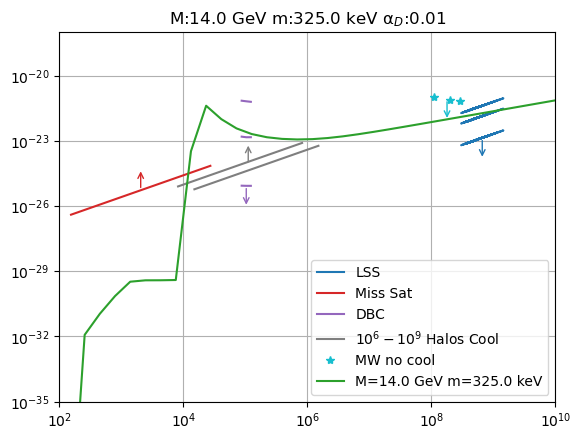

(100.0, 1.0e10)

In [3]:
adm = ADM(M=14,m=325,dα=0.01)
plotConstraints(adm)
PyPlot.xlim(1e2,1e10)

Plotted Constraints
nBH:1


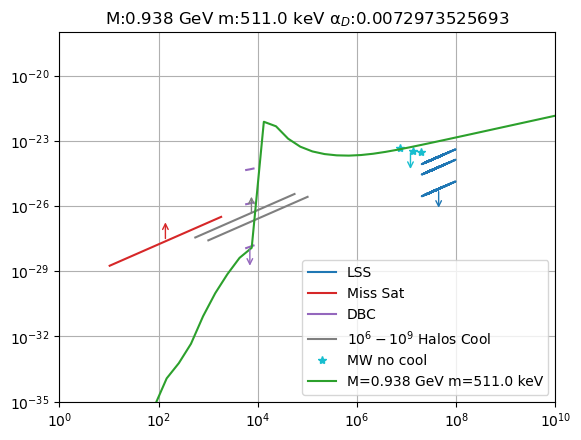

PyObject Text(0.5, 1.0, 'M:0.938 GeV m:511.0 keV α$_D$:0.0072973525693')

In [4]:
adm = ADM()
plotConstraints(adm)

## Example checkAllConstraints output
Here we show the output of the checkAllConstraints function for the two cases above. 

We should see one true each for LSS and DBC, 2 for DCO, and 3 for MW for the paper, and all the rest false.

For SM values, we should see two true for DBC, two true for DCO, one true for MW and all the rest false.

In [5]:
adm = ADM(M=14,m=325,dα=0.01)
checksDM = checkAllConstraints(get_Lambda,adm;n_test=1)
print("Paper values:\t")
display(checksDM)
isgood = (count(checksDM["DwG"])==0 && count(checksDM["LSS"])==1 && count(checksDM["DBC"])==1 
    && count(checksDM["DCO"])==2 && count(checksDM["MWG"])==3 ? "passed" : "failed")
println("Check: $(isgood)")
adm = ADM()
checksSM = checkAllConstraints(get_Lambda,adm;n_test=1)
print("SM values:\t")
display(checksSM)
isgood = (count(checksSM["DwG"])==0 && count(checksSM["LSS"])==0 && count(checksSM["DBC"])==2 
    && count(checksSM["DCO"])==2 && count(checksSM["MWG"])==1 ? "passed" : "failed")
println("Check: $(isgood)")

Paper values:	

Dict{Any, Any} with 5 entries:
  "DCO" => Any[true, true]
  "DwG" => Any[false]
  "LSS" => Any[false, false, true]
  "DBC" => Any[false, false, true]
  "MWG" => Any[true, true, true]

Check: passed
SM values:	

Dict{Any, Any} with 5 entries:
  "DCO" => Any[true, true]
  "DwG" => Any[false]
  "LSS" => Any[false, false, false]
  "DBC" => Any[false, true, true]
  "MWG" => Any[true, false, false]

Check: passed


# Plotting in ADM space
We want to plot which constraints are violated as a function of atomic binding energy vs rotational binding energy. That necessitates a fixed $\alpha=0.01$, $\xi=0.0005$, and $\epsilon=1$ for now. James' DAO constraints will probably include multiple $\xi$ values at the least

## Generate check grids
checks is a dictionary, where each key represents a constraint (must match the list of keys returned by checkAllConstraints) and the corresponding value is the number of times the constraint holds divided by the total number of possibilities. For example, the LSS constraint tests whether $\Lambda_{test}$ < $\Lambda_{LSS}$ over a range of $M_{halo}\rightarrow T$ for 3 given values of `f_lost` (alternatively, `plotConstraint` for LSS plots three lines). Then for a given ADM point, `checks["LSS"][adm]` will be equal to the (number of lines satisfied by $\Lambda_{ADM}$) $/ 3$. From the figures above, the $\{14,325,0.01\}$ point would be $1/3$, while the SM point would be 0. So for a given point, a really strong constraint would approach 0, and a really weak constraint would approach 1. This definition may switch in the future.

In [6]:
using LazyGrids
# make the binding energy grids. It's probably more interesting to plot vs binding energy scaling, so that's what we'll do
dα = 0.01
adm = ADM(;ξ=0.0005,dα)
rα = adm.rα

# Sampling in rm,rM space
# r_m = 10 .^ range(-2,2,length=10) # the name rm is used by Filesystem
# r_M = 10 .^ range(-2,3,length=10)
# r_m, r_M = ndgrid(r_m, r_M)
# ratom = adm.rα^2 .* r_m
# rrot = adm.rα^2 .* r_m.^2 ./ r_M

# Sampling in rATOM=rA, rROT=rR space
res = 10
rA = 10 .^ range(-1,2,length=res)
rR = 10 .^ range(-2,2, length=res)

# Converting to grid
rA, rR = ndgrid(rA, rR)
r_m = rA ./ rα^2
r_M = rA .^2 ./ (rα^2 .* rR)

# Want additional data points for the top-left and bottom-right regions in 
# the rm,rM space for the secondary r_m, r_M plot
# Solution: remake grid using r_m,r_M extrema at lower resolution.
# Merging with original grid was breaking contour algorithm (no way to 
# get back rectangular matrix without interpolation
scaling = 2 # decrease resolution by factor of 2
r_m2 = 10 .^ range(minimum(log10.(r_m[:])),
    maximum(log10.(r_m[:])),length=round(Int,size(r_m)[1]/scaling))
r_M2 = 10 .^ range(minimum(log10.(r_M[:])),
    maximum(log10.(r_M[:])),length=length(r_m2))
r_m2,r_M2 = ndgrid(r_m2,r_M2)

rV = rA .* sqrt.(rR ./ rA);

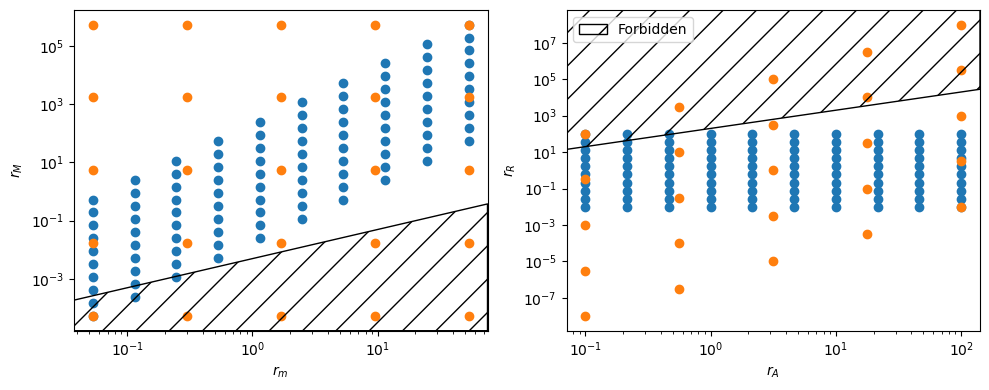

In [7]:
# Plot sample spacing
figure(figsize=(10,4))
subplot(121)
scatter(r_m,r_M,)
scatter(r_m2,r_M2,)
PyPlot.xscale("log")
PyPlot.yscale("log")
x = [PyPlot.xlim()...]
yl = PyPlot.ylim()
y = x / 200
PyPlot.fill_between(x,y,minimum(yl),edgecolor="k",facecolor="none",hatch="/",label="Forbidden")
PyPlot.xlim(x)
PyPlot.ylim(yl)
PyPlot.xlabel("\$r_m\$")
PyPlot.ylabel("\$r_M\$")
subplot(122)
scatter(rA,rR,)
scatter(rα.^2 .* r_m2,rα.^2 .* r_m2.^2 ./r_M2,)
PyPlot.xscale("log")
PyPlot.yscale("log")
x = [PyPlot.xlim()...]
yl = PyPlot.ylim()
y = 200 * x
PyPlot.fill_between(x,y,maximum(yl),edgecolor="k",facecolor="none",hatch="/",label="Forbidden")
PyPlot.xlim(x)
PyPlot.ylim(yl)
PyPlot.xlabel("\$r_A\$")
PyPlot.ylabel("\$r_R\$")
PyPlot.legend()
PyPlot.tight_layout()

Run grids. Since this is slow, we'll save the checks object so we don't have to run the grids computation each time. If you need to rerun for some reason, either set force to true or delete the `checks.jld2` file

In [9]:
using ProgressMeter
using JLD2
using UnPack

force = false
if !isfile("checks.jld2") || force

    checks = Dict("DwG"=>similar(rA),"LSS"=>similar(rA),"DBC"=>similar(rA), "DCO"=>similar(rA), "MWG"=>similar(rA))
    checks2 = copy(checks)
    n = length(eachindex(rA)) + length(eachindex(r_m2))
    p = Progress(n, dt=0.5,
             barglyphs=BarGlyphs('|','█', ['▁' ,'▂' ,'▃' ,'▄' ,'▅' ,'▆', '▇'],' ','|',),
             barlen=10,
             showspeed=true)
    for ind = eachindex(rA)
        set_m!(adm,rm=r_m[ind])
        set_M!(adm,rM=r_M[ind])
        #continue
        check = checkAllConstraints(get_Lambda,adm;n_test=1)
        for k in keys(checks)
            checks[k][ind] = count(check[k])/size(check[k])[1]
        end
        next!(p)
    end

    for ind = eachindex(r_m2)
        set_m!(adm,rm=r_m2[ind])
        set_M!(adm,rM=r_M2[ind])
        check = checkAllConstraints(get_Lambda,adm;n_test=1)
        for k in keys(checks2)
            checks2[k][ind] = count(check[k])/size(check[k])[1]
        end
        next!(p)
    end

    JLD2.jldopen("checks.jld2","w") do file
        @pack! file = adm,r_m,r_M,rA,rR,rV,checks,r_m2,r_M2,checks2
    end
else
    # THIS IS SO OBNOXIOUS - JULIA MODULE LOADING SUUUUUCKS
    moduleloc(mm::Module) = first(functionloc(mm.eval, (Any,)))
    file = JLD2.jldopen("checks.jld2","r";typemap=Dict("Main.$(moduleloc(ADM_mod)).ADM_mod.ADM"=>ADM))
    try
        @unpack adm,r_m,r_M,rA,rR,rV,checks,r_m2,r_M2,checks2 = file
    catch ex
        if isa(ex,KeyError)
            # still using old checks file
            @unpack adm,r_m,r_M,rA,rR,rV,checks = file
        end
    end
    close(file)
end

In [10]:
println(size(r_m))
println(size(rA))
println(size(r_m2))

(40, 40)
(40, 40)
(5, 5)


## Plot Check grids

**Warning**: These plots were generated using an older version of Get_Lambda and do not reflect the current status. When the new, DK-based version of Get_Lambda is finished, these plots will be regenerated and this message removed.

sys:1: UserWarning: Legend does not support handles for QuadMesh instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler


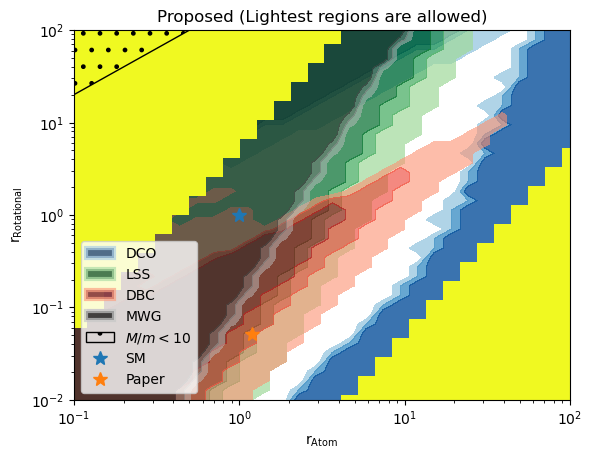

PyObject <matplotlib.legend.Legend object at 0x7f50dca991d0>

In [11]:
using PyPlot

fig = figure()
x = rA
y = rR
cols = Dict("LSS"=>"Greens","DCO"=>"Blues","DBC"=>"Reds","MWG"=>"Greys")
alpha_offset = (length(keys(cols))-1)/10
nanarray = fill(NaN,(2))
hndls = []
for k in keys(checks)
    if !(k in keys(cols))
        continue
    end
    #masked = convert(Matrix{Union{Float64,Missing}},checks[k])
    # matplotlib uses NaNs to mask data apparently
    masked = 1.0 .- copy(checks[k])
    masked[masked .== 0.0] .= NaN
    # note if we want hatches we need to switch back to pcolor - this leaves lines between the boxes - 
    # see https://stackoverflow.com/questions/8263769/hide-contour-linestroke-on-pyplot-contourf-to-get-only-fills
    # for a potential solution
    #pcolormesh(x,y, masked,cmap=cols[k],alpha=.5+alpha_offset,)
    conts = contourf(x,y, 1 .-checks[k],cmap=cols[k],levels=3,alpha=0.5+alpha_offset)
    conts.collections[1].set_alpha(0)
    #conts.collections[end].set_label(k)
    #push!(hndls,conts.legend_elements()[1][1])
    
    cmap = ColorMap(cols[k])
    #println("$k: $(cols[k]): $(cmap(1))")
    
    # the following comes from 
    # https://stackoverflow.com/questions/57024194/how-to-create-an-ax-legend-method-for-contourf-plots-that-doesnt-require-pass/57030414#57030414
    # and has been modified to fit your Julia screen
    # pass labels to proxies and place proxies in loop
    proxy = plt.Rectangle((NaN, NaN), NaN, 1, fc=cmap(0.999), ec=cmap(0.33), 
                           alpha=0.7, linewidth=3, label=k)
    # pass proxies to ax.patches
    ax = gca()
    ax.add_patch(proxy)
    
    # Need to figure out a way to label colors without using a hundred color bars
    alpha_offset -= 0.1
    clim(0,1)
end
PyPlot.xlim(extrema(x))
PyPlot.xlim(0.1,maximum(x))
yl = PyPlot.ylim(extrema(y))
flag = r_M.<.1 .|| 
       r_M.>1000 .|| 
       r_m.<0.001 .|| 
       r_m.>100
pcolormesh(x,y,1 ./(flag),cmap=get_cmap("plasma",2).reversed(),label="\$r_M < 1\$")
x = unique(rA)
y = 200 * x
#plot(x,y,linestyle="dashed",color="black")
PyPlot.fill_between(x,y,maximum(yl),edgecolor="k",facecolor="none",hatch=".",label="\$M/m < 10\$")
PyPlot.xscale("log")
PyPlot.yscale("log")
PyPlot.xlabel("r\$_{\\rm Atom}\$")
PyPlot.ylabel("r\$_{\\rm Rotational}\$")
append!(hndls,plotExamplePoints())
title("Proposed (Lightest regions are allowed)")
#display(hndls)
PyPlot.legend(loc="lower left")

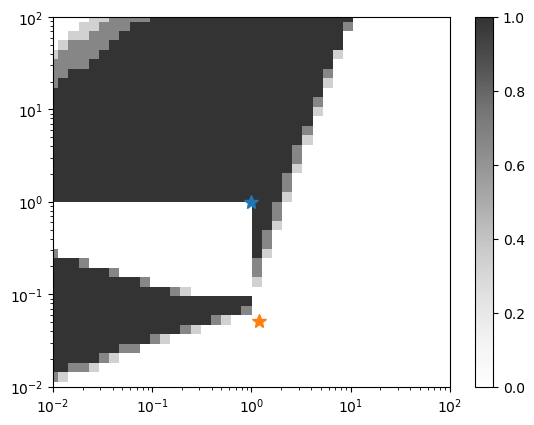

In [29]:
using PyPlot

fig = figure()
x = rA
y = rR
k = "MWG"
masked = 1 .- copy(checks[k])
masked[masked.==0.0] .= NaN
pcolormesh(x,y,masked,label=k,cmap=cols[k],alpha=0.8,edgecolor="none")
PyPlot.xlim(extrema(x))
PyPlot.ylim(extrema(y))
PyPlot.xscale("log")
PyPlot.yscale("log")
plotExamplePoints()
PyPlot.colorbar()
PyPlot.clim(0,1)

1 level: 0.0 PyObject <matplotlib.collections.PathCollection object at 0x7fed68a62090>
2 level: 0.25 PyObject <matplotlib.collections.PathCollection object at 0x7fed68a62110>
3 level: 0.5 PyObject <matplotlib.collections.PathCollection object at 0x7fed68a62d50>
4 level: 0.75 PyObject <matplotlib.collections.PathCollection object at 0x7fed68a638d0>


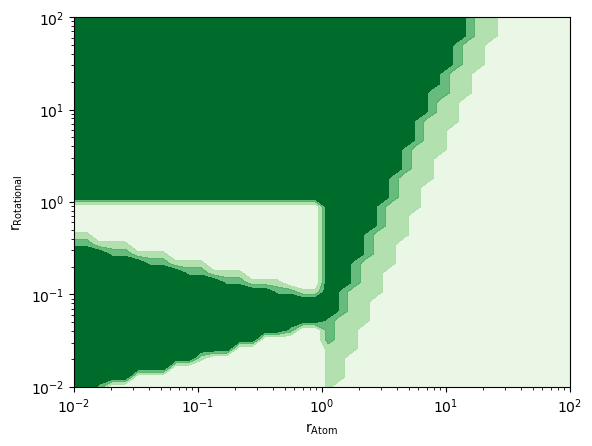

In [30]:
k="LSS"
conts = contourf(x,y, 1 .-checks[k],cmap=cols[k],levels=3,alpha=0.5+alpha_offset,)
PyPlot.xlim(extrema(x))
PyPlot.ylim(extrema(y))
PyPlot.xscale("log")
PyPlot.yscale("log")
PyPlot.xlabel("r\$_{\\rm Atom}\$")
PyPlot.ylabel("r\$_{\\rm Rotational}\$")
for i in eachindex(conts.collections)
    println("$i level: $(conts.levels[i]) $(conts.collections[i])")
end
conts.collections[4].set_alpha(1)

In [39]:
using PyPlot

fig = figure()
x = r_m2
y = r_M2
cols = Dict("LSS"=>"Greens","DCO"=>"Blues","DBC"=>"Reds","MWG"=>"Greys")
alpha_offset = (length(keys(cols))-1)/10
nanarray = fill(NaN,(2))
hndls = []
for k in keys(checks2)
    if !(k in keys(cols))
        continue
    end
    #masked = convert(Matrix{Union{Float64,Missing}},checks[k])
    # matplotlib uses NaNs to mask data apparently
    masked = 1.0 .- copy(checks2[k])
    masked[masked .== 0.0] .= NaN
    # note if we want hatches we need to switch back to pcolor - this leaves lines between the boxes - 
    # see https://stackoverflow.com/questions/8263769/hide-contour-linestroke-on-pyplot-contourf-to-get-only-fills
    # for a potential solution
    #pcolormesh(x,y, masked,cmap=cols[k],alpha=.5+alpha_offset,)
    conts = contourf(x,y, 1 .-checks2[k],cmap=cols[k],levels=3,alpha=0.5+alpha_offset)
    conts.collections[1].set_alpha(0)
    cmap = ColorMap(cols[k])
    #println("$k: $(cols[k]): $(cmap(1))")
    proxy = plt.Rectangle((NaN, NaN), NaN, 1, fc=cmap(0.999), ec=cmap(0.33), 
                           alpha=0.7, linewidth=3, label=k)
    ax = gca()
    ax.add_patch(proxy)
    alpha_offset -= 0.1
    clim(0,1)
end
PyPlot.xlim(extrema(x))
PyPlot.ylim(extrema(y))
PyPlot.xscale("log")
PyPlot.yscale("log")
PyPlot.xlabel("r\$_{m}\$")
PyPlot.ylabel("r\$_{M}\$")
append!(hndls,plotExamplePoints(use_m=true))
title("Shaded region is disallowed")
#display(hndls)
PyPlot.legend()

LoadError: PyError ($(Expr(:escape, :(ccall(#= /home/strato/.julia/packages/PyCall/ilqDX/src/pyfncall.jl:43 =# @pysym(:PyObject_Call), PyPtr, (PyPtr, PyPtr, PyPtr), o, pyargsptr, kw))))) <class 'TypeError'>
TypeError('Shapes of x (5, 5) and z (10, 10) do not match')
  File "/home/strato/.conda/envs/gizmo/lib/python3.11/site-packages/matplotlib/pyplot.py", line 2537, in contourf
    __ret = gca().contourf(
            ^^^^^^^^^^^^^^^
  File "/home/strato/.conda/envs/gizmo/lib/python3.11/site-packages/matplotlib/__init__.py", line 1442, in inner
    return func(ax, *map(sanitize_sequence, args), **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/strato/.conda/envs/gizmo/lib/python3.11/site-packages/matplotlib/axes/_axes.py", line 6467, in contourf
    contours = mcontour.QuadContourSet(self, *args, **kwargs)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/strato/.conda/envs/gizmo/lib/python3.11/site-packages/matplotlib/contour.py", line 769, in __init__
    kwargs = self._process_args(*args, **kwargs)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/strato/.conda/envs/gizmo/lib/python3.11/site-packages/matplotlib/contour.py", line 1411, in _process_args
    x, y, z = self._contour_args(args, kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/strato/.conda/envs/gizmo/lib/python3.11/site-packages/matplotlib/contour.py", line 1450, in _contour_args
    x, y, z = self._check_xyz(x, y, z_orig, kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/strato/.conda/envs/gizmo/lib/python3.11/site-packages/matplotlib/contour.py", line 1496, in _check_xyz
    raise TypeError(


# Testing DAO, HMF code

**Warning:** This code is currently not in a useable state. Feel free to experiment with it, but don't blame Michael if things are weird.

In [13]:
include("constraints.jl")
using .ADM_mod
include("dao/daohmf.jl")
include("dao/api.jl")

hmfcdm (generic function with 2 methods)

In [14]:
include("dao/api.jl")
adm = ADM()
z = 100
hf = hmf(adm, z)
hfcdm = hmfcdm(adm, z)

LoadError: UndefVarError: `ub` not defined

`hf` and `hfcdm` are functions of `m`, but it's unclear to me whether that's the ADM parameter $m$ or the halo mass $M_{halo}$. I'm guessing it's the halo mass, presumably in solar masses. To check, we'll plot a _huge_ range of masses, hopefully the correct scale will be obvious

In [15]:
using PyPlot

mtest = 10 .^ range(-100,36,length=100) # solar masses
hofm = hfcdm(mtest)
if any(hofm.>0)
    plt.loglog(mtest,hofm)
else
    plt.semilogx(mtest,hofm)
end
println(hofm[1:10])
plt.xlim(minimum(mtest),maximum(mtest))

LoadError: UndefVarError: `hfcdm` not defined